In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ngwl-predict-customer-churn/sample_submission.csv
/kaggle/input/ngwl-predict-customer-churn/sample_submission_from_kaggle_change_sep.csv
/kaggle/input/ngwl-predict-customer-churn/misc/user_profiles.csv
/kaggle/input/ngwl-predict-customer-churn/misc/addresses.csv
/kaggle/input/ngwl-predict-customer-churn/misc/master_categories.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-21.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-03.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-07.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-29.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-25.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-15.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-01.csv
/kaggle/input/ngwl-predict-customer-churn/line_items06/line_items_2020-06-19.csv
/kaggl

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
TRAIN_PATH = '/kaggle/input/ngwl-predict-customer-churn/train/train.csv'
SAMPLE_PATH = '/kaggle/input/ngwl-predict-customer-churn/sample_submission.csv'
ADDRESS_PATH = '/kaggle/input/ngwl-predict-customer-churn/misc/addresses.csv'
SHIPMENTS_PATH = list(Path('/kaggle/input/ngwl-predict-customer-churn/shipments/').glob('*.csv'))
ACTION_PATH = '/kaggle/input/ngwl-predict-customer-churn/messages/actions.csv'
MESSAGE_PATH = '/kaggle/input/ngwl-predict-customer-churn/messages/messages.csv'
USER_PATH = '/kaggle/input/ngwl-predict-customer-churn/misc/user_profiles.csv'
MASTER_CATEGORIES = '/kaggle/input/ngwl-predict-customer-churn/misc/master_categories.csv'

LINE_ITEMS_DIRS = list(Path('/kaggle/input/ngwl-predict-customer-churn/').glob('line*'))
LINE_ITEMS_FILES = list([filename for dir_ in LINE_ITEMS_DIRS for filename in dir_.glob('*.csv')])

In [4]:
def divide_digits(digits):
    return '{0:,}'.format(int(digits)).replace(',', ' ')

In [5]:
train = pd.read_csv(TRAIN_PATH)
print(f"unique phone numbers {divide_digits(train['phone_id'].nunique())}")
print(train['target'].value_counts())
train

unique phone numbers 284 449
1.0    580255
0.0    579321
Name: target, dtype: int64


,phone_id,order_completed_at,target
0,19843,2020-01,1.0
1,19843,2020-02,0.0
2,19843,2020-03,0.0
3,19843,2020-04,0.0
4,19843,2020-05,0.0
...,...,...,...
1159571,23853,2020-03,0.0
1159572,23853,2020-04,0.0
1159573,23853,2020-05,0.0
1159574,23853,2020-06,1.0


### shipments tables

In [6]:
shipments = pd.DataFrame()
for path in SHIPMENTS_PATH:
    shipments = shipments.append(pd.read_csv(path), ignore_index=False)
shipments.head()

,user_id,ship_address_id,shipment_id,order_id,order_created_at,order_completed_at,shipment_starts_at,retailer,s.order_state,shipment_state,s.city_name,s.store_id,total_cost,rate,dw_kind,promo_total,total_weight,platform,os,shipped_at
0,11019,171906,322307,2156687,2017-08-03 21:25:23,2020-02-18 14:07:00,2020-02-20 07:00:00,METRO,complete,shipped,Москва,21,168.0,0,courier,0.0,30170,web,windows,2020-02-20 08:08:54
1,62278,278832,387023,3021953,2018-03-02 17:22:04,2020-01-03 13:09:26,2020-01-03 17:00:00,METRO,complete,shipped,Москва,10,98.0,0,courier,-150.0,11305,web,windows,2020-01-03 18:10:40
2,905126,468407,388943,3018198,2018-02-28 11:32:47,2020-02-12 12:39:28,2020-02-13 11:00:00,METRO,complete,shipped,Москва,21,98.0,5,courier,0.0,13589,app,ios,2020-02-13 12:33:53
3,21412,61962,421048,3030227,2018-03-07 20:37:27,2020-01-25 11:58:56,2020-01-25 18:00:00,METRO,complete,shipped,Москва,8,158.0,0,courier,0.0,9726,web,mac,2020-01-25 19:55:32
4,42110,378297,442659,2923996,2017-12-24 11:19:04,2020-01-07 14:30:44,2020-01-07 19:00:00,METRO,complete,shipped,Москва,2,163.0,0,courier,0.0,30323,web,windows,2020-01-07 19:51:37


In [7]:
shipments.order_created_at = shipments.order_created_at.apply(lambda x: x[:10])
shipments.shipment_starts_at = shipments.shipment_starts_at.apply(lambda x: x[:10])
shipments

,user_id,ship_address_id,shipment_id,order_id,order_created_at,order_completed_at,shipment_starts_at,retailer,s.order_state,shipment_state,s.city_name,s.store_id,total_cost,rate,dw_kind,promo_total,total_weight,platform,os,shipped_at
0,11019,171906,322307,2156687,2017-08-03,2020-02-18 14:07:00,2020-02-20,METRO,complete,shipped,Москва,21,168.0,0,courier,0.0,30170,web,windows,2020-02-20 08:08:54
1,62278,278832,387023,3021953,2018-03-02,2020-01-03 13:09:26,2020-01-03,METRO,complete,shipped,Москва,10,98.0,0,courier,-150.0,11305,web,windows,2020-01-03 18:10:40
2,905126,468407,388943,3018198,2018-02-28,2020-02-12 12:39:28,2020-02-13,METRO,complete,shipped,Москва,21,98.0,5,courier,0.0,13589,app,ios,2020-02-13 12:33:53
3,21412,61962,421048,3030227,2018-03-07,2020-01-25 11:58:56,2020-01-25,METRO,complete,shipped,Москва,8,158.0,0,courier,0.0,9726,web,mac,2020-01-25 19:55:32
4,42110,378297,442659,2923996,2017-12-24,2020-01-07 14:30:44,2020-01-07,METRO,complete,shipped,Москва,2,163.0,0,courier,0.0,30323,web,windows,2020-01-07 19:51:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400958,162999,6232177,4865438,9058949,2020-04-26,2020-04-29 20:49:45,2020-04-30,METRO,complete,shipped,Нижний Новгород,85,158.0,0,courier,0.0,14016,web,windows,2020-04-30 08:19:49
400959,1693390,6420543,4865472,9246986,2020-04-29,2020-04-29 20:47:58,2020-04-30,Лента,complete,shipped,Ростов-на-Дону,128,98.0,0,courier,0.0,6005,app,ios,2020-04-30 09:00:47
400960,1221800,6420173,4865480,9246607,2020-04-29,2020-04-29 20:56:30,2020-04-30,Ашан,complete,shipped,Москва,197,158.0,0,courier,0.0,24705,app,ios,2020-04-30 08:41:31
400961,1460711,6420424,4865577,9246877,2020-04-29,2020-04-29 20:59:36,2020-04-30,Лента,complete,shipped,Краснодар,139,99.0,0,courier,0.0,4375,web,windows,2020-04-30 07:27:23


In [8]:
print(f"unique clients - {divide_digits(shipments['user_id'].nunique())}")
print(f"unique addresses - {divide_digits(shipments['ship_address_id'].nunique())}")
print(f"unique shipment_id - {divide_digits(shipments['shipment_id'].nunique())}")
print(f"unique order_id - {divide_digits(shipments['order_id'].nunique())}")

unique clients - 654 907
unique addresses - 2 226 096
unique shipment_id - 2 260 686
unique order_id - 2 226 106


### how many clients canceled orders

In [9]:
print(f"canceled {round(shipments['s.order_state'].value_counts()[1] * 100 / shipments.shape[0], 2)}%", end='')
print(f" ({shipments['s.order_state'].value_counts()[1]} out of {shipments.shape[0]})")

canceled 7.87% (177848 out of 2260686)


In [10]:
# get from date only month and year
shipments.order_completed_at = shipments.order_completed_at.apply(lambda x: x[:7])

In [11]:
shipments['is_canceled'] = shipments['s.order_state'] == 'canceled'
shipments['total_orders'] = True
shipments.groupby(by=['user_id', 'ship_address_id', 'order_completed_at'], as_index=False).sum()[['user_id', 'ship_address_id', 'order_completed_at', 'is_canceled', 'total_orders']]\
         .sort_values(by='is_canceled', ascending=False)

,user_id,ship_address_id,order_completed_at,is_canceled,total_orders
109514,196923,6589785,2020-05,4,4
1457153,1760380,8435804,2020-07,3,3
510912,836899,11295155,2020-08,3,3
187233,296015,11058859,2020-07,3,3
371233,651005,12388363,2020-08,3,3
...,...,...,...,...,...
778806,1161817,4263096,2020-03,0,1
778805,1161816,4264182,2020-03,0,1
778804,1161815,4265555,2020-03,0,1
778803,1161810,3943323,2020-03,0,1


In [12]:
# merge train and shipments
address = pd.read_csv(ADDRESS_PATH)
address.rename(columns={'id': 'ship_address_id'}, inplace=True)
merged_train_shipments_or = train.merge(address, on='phone_id', how='left')\
                              .drop_duplicates(subset=['phone_id', 'ship_address_id'])\
                              .merge(shipments, on=['ship_address_id', 'order_completed_at'])
    
merged_train_shipments_or

,phone_id,order_completed_at,target,ship_address_id,user_id,shipment_id,order_id,order_created_at,shipment_starts_at,retailer,...,total_cost,rate,dw_kind,promo_total,total_weight,platform,os,shipped_at,is_canceled,total_orders
0,19843,2020-01,1.0,3064377,810074,2163606,5919719,2020-01-25,2020-01-26,METRO,...,0.0,0,courier,-2000.0,2580,web,windows,NaN,True,True
1,173074,2020-05,0.0,6837435,1777712,5195426,9680696,2020-05-07,2020-05-08,METRO,...,98.0,0,courier,0.0,3225,web,windows,2020-05-08 07:36:38,False,True
2,101944,2020-01,0.0,3131130,57430,2214984,5988200,2020-01-28,2020-01-30,Ашан,...,0.0,0,courier,0.0,2800,app,other,NaN,True,True
3,101944,2020-01,0.0,3171098,844049,2227144,6030918,2020-01-30,2020-01-31,METRO,...,98.0,0,courier,0.0,7500,app,other,NaN,True,True
4,101944,2020-01,0.0,3171105,844050,2227147,6030924,2020-01-30,2020-01-31,METRO,...,98.0,0,courier,0.0,7500,app,other,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440356,320024,2020-05,1.0,7621082,1925465,6094649,10524874,2020-05-21,2020-05-28,METRO,...,0.0,4,courier,0.0,74170,web,ios,2020-05-28 17:09:54,False,True
440357,23853,2020-01,0.0,2871091,746289,2053796,5720160,2020-01-15,2020-01-16,METRO,...,158.0,0,courier,0.0,17000,app,android,NaN,True,True
440358,23853,2020-01,0.0,2871147,746289,2053827,5722412,2020-01-15,2020-01-16,METRO,...,158.0,0,courier,0.0,17000,app,android,NaN,True,True
440359,23853,2020-01,0.0,2871157,746289,2053834,5722422,2020-01-15,2020-01-16,METRO,...,98.0,0,courier,0.0,17000,app,android,NaN,True,True


In [15]:
# get how many clients cancel order and total number of order at each month
merged_train_shipments['is_canceled'] = merged_train_shipments['s.order_state'] == 'canceled'
merged_train_shipments['total_orders'] = True
merged_train_shipments.groupby(by=['user_id', 'ship_address_id', 'phone_id', 'order_completed_at'], as_index=False).sum()\
        [['phone_id', 'user_id', 'ship_address_id', 'order_completed_at', 'is_canceled', 'total_orders']]\
         .sort_values(by='is_canceled', ascending=False)

,phone_id,user_id,ship_address_id,order_completed_at,is_canceled,total_orders
398574,459046,2319087,9856473,2020-07,3,3
255993,86028,1739580,6611524,2020-05,3,3
286805,94177,1829877,8308101,2020-06,3,3
425389,624738,2492230,10632121,2020-07,3,3
348973,268452,2065675,8855643,2020-06,3,3
...,...,...,...,...,...,...
149904,276121,1309093,4830321,2020-04,0,1
149903,232067,1309079,4700143,2020-03,0,1
149902,504170,1309075,4860408,2020-03,0,1
149900,504069,1309060,4825963,2020-03,0,1


### trying to find insights

In [ ]:
users = pd.read_csv(USER_PATH)
address = pd.read_csv(ADDRESS_PATH)
address.rename(columns={'id': 'ship_address_id'}, inplace=True)

users = users.drop_duplicates(subset='user_id')
users = users.merge(shipments, on='user_id', how='left')
users = users.merge(address, on='ship_address_id', how='left').merge(train, on='phone_id', how='left')

In [ ]:
users.iloc[:, 10:]

In [ ]:
corr_with_target = users.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**total cost**

In [ ]:
col = 'total_cost'
limit_bal_with_target = users[[col, TARGET]]
limit_bal = limit_bal_with_target[col]
limit_bal_target_0 = limit_bal[limit_bal_with_target[TARGET] == 0]
limit_bal_target_1 = limit_bal[limit_bal_with_target[TARGET] == 1]

fig, ax = plt.subplots(figsize=(10, 5))

# ax.set_yscale('log')

sns.kdeplot(limit_bal_target_0, ax=ax, shade=True, label='Отток', color='r')
sns.kdeplot(limit_bal_target_1, ax=ax, shade=True, label='Активный', color='g')

plt.xlabel(col)
plt.title(f'{col} grouped by target variable')
plt.show()

**rate**

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
# ax.set_yscale('log')
sns.countplot(x="rate", ax=ax, hue=TARGET, data=users)
plt.title('Rate grouped by churn')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
# ax.set_yscale('log')
sns.countplot(x="rate", ax=ax, hue=TARGET, data=users[users.rate.isin([1, 2, 3])])
plt.title('Rate grouped by churn')
plt.legend(title='Target', loc='upper right')

plt.show()

**Platform**

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
# ax.set_yscale('log')
sns.countplot(x="platform", ax=ax, hue=TARGET, data=users)
plt.title('Platform grouped by churn')
plt.legend(title='Target', loc='upper right')

plt.show()

**s.order_state**

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_yscale('log')
sns.countplot(x="s.order_state", ax=ax, hue=TARGET, data=users)
plt.title('S.order_state grouped by churn')
plt.legend(title='Target', loc='upper right')

plt.show()

**promo_total**

In [ ]:
users['promo_total'].hist()

In [ ]:
bins=[users['promo_total'].min(), -3000, -2000, -1000, -500, -10, 0]
users['promo_total_cat'] = pd.cut(users['promo_total'], bins=bins, labels=[5, 4, 3, 2, 1, 0])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_yscale('log')
sns.countplot(x="promo_total_cat", ax=ax, hue=TARGET, data=users)
plt.title('promo_total_cat grouped by churn')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
tmp = shipments[shipments.total_cost < 6000]
# sns.boxplot(x=tmp)
tmp

### items

In [ ]:
%%time
items = pd.DataFrame()
for path in tqdm(LINE_ITEMS_FILES):
    items = items.append(pd.read_csv(path), ignore_index=False)
items.head()

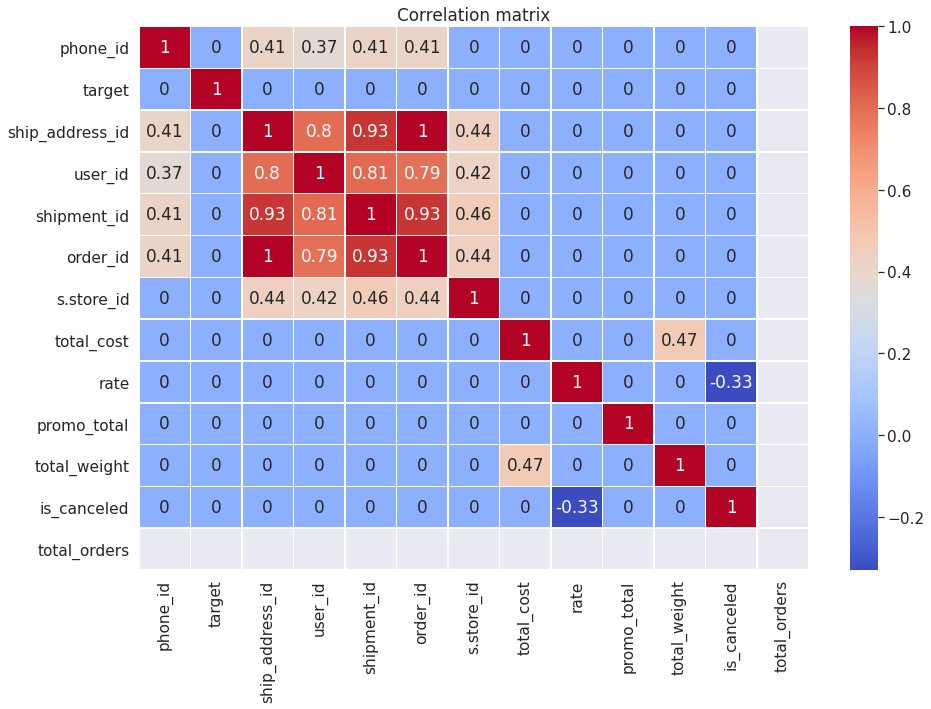

In [14]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = merged_train_shipments_or.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

## modeling

In [15]:
# add users data to train
from dateutil.parser import parse
from datetime import date

users = pd.read_csv(USER_PATH)

users.head()
users =  users.dropna()
users = users.drop_duplicates(subset='user_id')

users["bdate"] = users["bdate"].apply(lambda x: parse(x))
users["bdate"] = users["bdate"].astype('datetime64[ns]')

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

users["age"] = users["bdate"].apply(lambda x: calculate_age(x))

In [16]:
merged_train_shipments = merged_train_shipments_or.copy()

In [17]:
print(merged_train_shipments.shape)
merged_train_shipments = merged_train_shipments.merge(users, on='user_id', how='left')
print(merged_train_shipments.shape)

# print(test_data.shape)
# test_data = test_data.merge(users, on='user_id', how='left')
# print(test_data.shape)

(440361, 24)
(440361, 27)


In [18]:
min_promo_cat = merged_train_shipments['promo_total'].min()

def promo_total_2cat(X):
    bins=[min_promo_cat, -3000, -2000, -1000, -500, -10, 0]
    X['promo_total_cat'] = pd.cut(X['promo_total'], bins=bins, labels=[5, 4, 3, 2, 1, 0])
    return X


merged_train_shipments = promo_total_2cat(merged_train_shipments)
# test_data = promo_total_2cat(test_data)

In [17]:
max_total_cost_cat = merged_train_shipments['total_cost'].max()

def total_cost_2cat(X):
    bins=[0, 50, 100, 200, 400, 1000, max_total_cost_cat]
    X['total_cost_cat'] = pd.cut(X['total_cost'], bins=bins, labels=False)
    return X


merged_train_shipments = total_cost_2cat(merged_train_shipments)
# test_data = total_cost_2cat(test_data)

In [46]:
tqdm.pandas()
from datetime import datetime
def get_data_diff(x):
    try:
        
        diff = datetime.strptime(x['shipment_starts_at'], '%Y-%m-%d') \
                - datetime.strptime(x['order_created_at'], '%Y-%m-%d')
        return int(str(diff).split(' ')[0])
    except Exception as e:
        return 0
    
merged_train_shipments['deleviry_diff'] = merged_train_shipments.progress_apply(get_data_diff, axis=1)
# test_data['deleviry_diff'] = test_data.progress_apply(get_data_diff, axis=1)

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 440361/440361 [00:32<00:00, 13736.32it/s]


In [19]:
merged_train_shipments['perc_promo_total'] = merged_train_shipments['promo_total'] / merged_train_shipments['total_cost']

In [20]:
from sklearn.metrics import classification_report

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """Отчет с метриками модели"""
    
    print('Train\n\n' + classification_report(y_train_true, y_train_pred))
    print('Test\n\n' + classification_report(y_test_true, y_test_pred))
    print('Confusion Matrix\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
    
def evaluate_preds(model, y_train, y_test, X_train, X_test):
    """Валидация модели, вывод отчетов"""
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [22]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [23]:
CAT_FEATURES = ['phone_id', 'order_completed_at', 'ship_address_id', 'user_id', 'shipment_id', 'order_id', 'order_created_at',
                'shipment_starts_at', 'retailer', 's.order_state', 'shipment_state', 's.city_name', 's.store_id', 'rate', 'dw_kind',
                'platform', 'os', 'is_canceled']
NUM_FEATURES = ['total_cost', 'promo_total', 'total_weight']
TARGET = 'target'

In [24]:
print(merged_train_shipments.columns)
merged_train_shipments.shape,# test_data.shape

Index(['phone_id', 'order_completed_at', 'target', 'ship_address_id',
       'user_id', 'shipment_id', 'order_id', 'order_created_at',
       'shipment_starts_at', 'retailer', 's.order_state', 'shipment_state',
       's.city_name', 's.store_id', 'total_cost', 'rate', 'dw_kind',
       'promo_total', 'total_weight', 'platform', 'os', 'shipped_at',
       'is_canceled', 'total_orders', 'gender', 'bdate', 'age',
       'promo_total_cat', 'perc_promo_total'],
      dtype='object')


((440361, 29),)

In [44]:
CAT_FEATURES = ['user_id', 'ship_address_id', 'shipment_id', 'order_id', 
#                 'order_created_at',
#                 'shipment_starts_at',
                'retailer', 's.order_state', 'shipment_state',
               's.city_name', 's.store_id', 
#                 'total_cost',
                'rate', 'dw_kind', 'total_weight', 'platform', 'os', 'shipped_at',
               'is_canceled', 'total_orders', 'phone_id', 'order_completed_at',
                'promo_total_cat',
###                 'total_cost_cat',
                'gender', 'bdate', 'age', 
                'deleviry_diff', 
                'perc_promo_total']

In [47]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

X = merged_train_shipments[CAT_FEATURES]

# X = users[CAT_FEATURES]

for col in tqdm(X.columns):
    X[col] = X[col].astype('str')

X.fillna('0', inplace=True)
    
y = merged_train_shipments[TARGET]
# y = users[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)
X_train.shape, X_test.shape

  0%|          | 0/25 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
100%|██████████| 25/25 [00:09<00:00,  2.53it/s]
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


((352288, 25), (88073, 25))

In [48]:
%%time
params_model = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
#     'one_hot_max_size': 20,
    'early_stopping_rounds': 20,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

cat = CatBoostClassifier(**params_model, cat_features=CAT_FEATURES, depth=4,
                        iterations=100,
                        learning_rate=0.3,
                        l2_leaf_reg=3.5,
                        bagging_temperature=1.5)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))

CPU times: user 3min 17s, sys: 10.1 s, total: 3min 27s
Wall time: 1min 1s


In [49]:
evaluate_preds(cat, y_train, y_test, X_train, X_test)

Train

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     72617
         1.0       1.00      1.00      1.00    279671

    accuracy                           1.00    352288
   macro avg       1.00      1.00      1.00    352288
weighted avg       1.00      1.00      1.00    352288

Test

              precision    recall  f1-score   support

         0.0       0.49      0.95      0.64     18154
         1.0       0.98      0.74      0.84     69919

    accuracy                           0.78     88073
   macro avg       0.73      0.85      0.74     88073
weighted avg       0.88      0.78      0.80     88073

Confusion Matrix

col_0     0.0    1.0
target              
0.0     17312    842
1.0     18338  51581


In [50]:
print(classification_report(y_test, np.where(cat.predict_proba(X_test)[:, 1] > 0.3, 1, 0)))

              precision    recall  f1-score   support

         0.0       0.75      0.62      0.68     18154
         1.0       0.91      0.95      0.93     69919

    accuracy                           0.88     88073
   macro avg       0.83      0.79      0.80     88073
weighted avg       0.87      0.88      0.88     88073



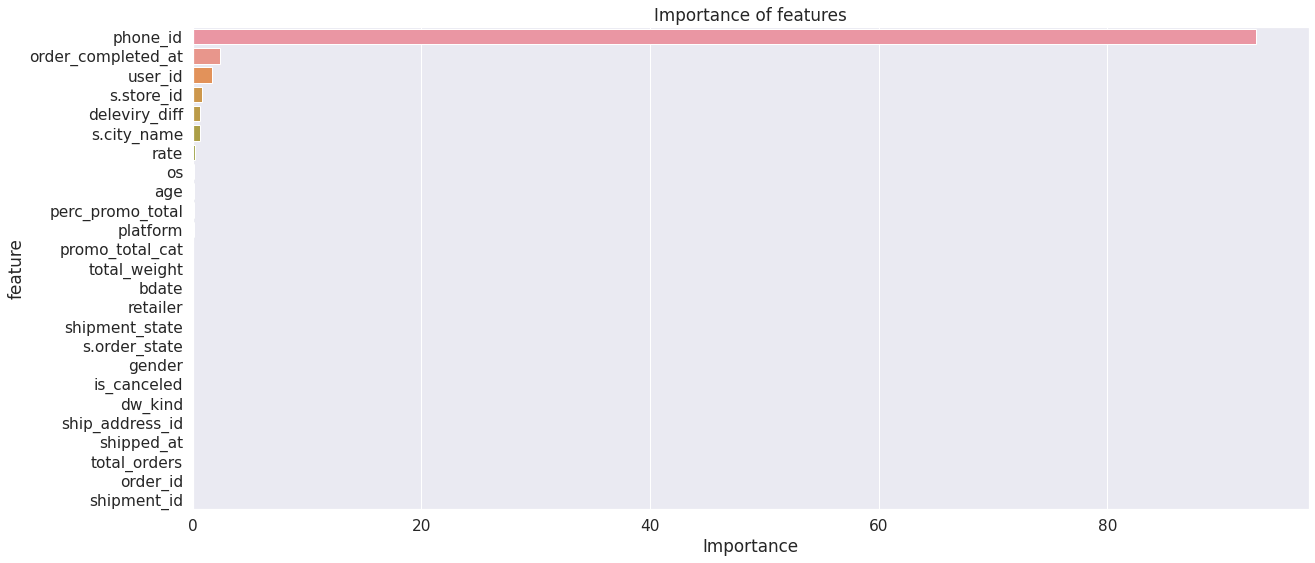

In [51]:
important_features = show_feature_importances(CAT_FEATURES, cat.feature_importances_, get_top=8)

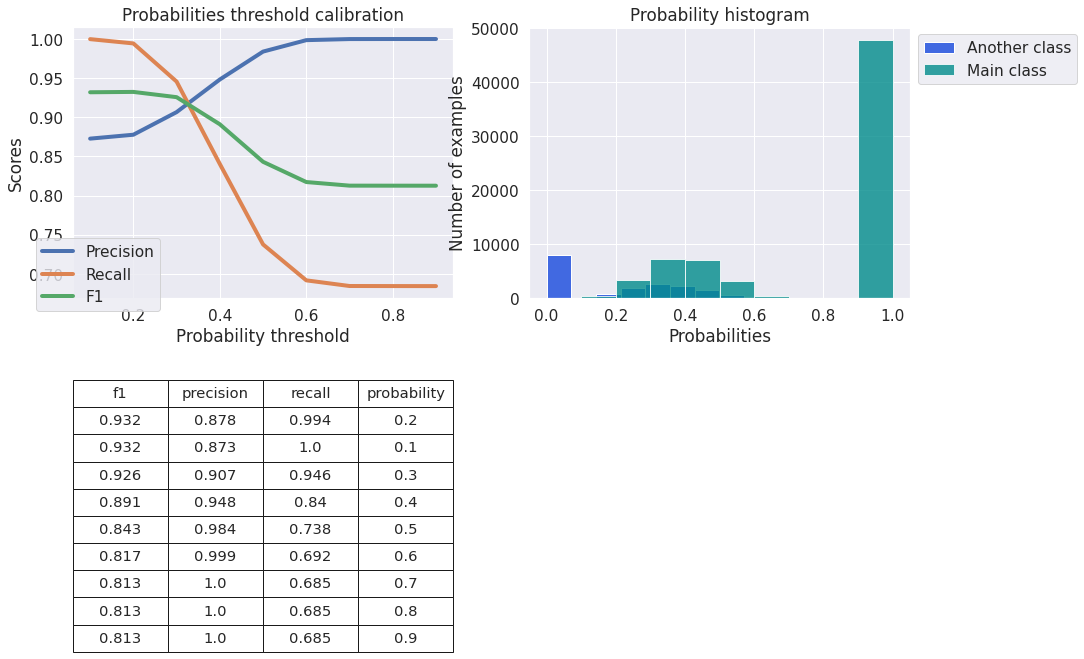

In [52]:
show_proba_calibration_plots(cat.predict_proba(X_test)[:, 1], y_test)

## predicition

In [53]:
sample = pd.read_csv(SAMPLE_PATH, sep=';')
sample

,Id,Predicted
0,19843,NaN
1,471287,NaN
2,342522,NaN
3,457799,NaN
4,233778,NaN
...,...,...
214604,16841,NaN
214605,69348,NaN
214606,594974,NaN
214607,320024,NaN


In [33]:
test_data_origin = sample.merge(address, left_on='Id', right_on='phone_id', how='left')\
                          .drop_duplicates(subset=['phone_id', 'ship_address_id'])\
                          .merge(shipments, on=['ship_address_id'], how='left')

In [34]:
test_data_origin = test_data_origin.sort_values(by='order_completed_at').drop_duplicates(subset=['phone_id', 'order_completed_at'], keep='last')
test_data_origin = test_data_origin.sort_values(by='order_completed_at').drop_duplicates(subset=['Id'], keep='last')
test_data_origin

,Id,Predicted,ship_address_id,phone_id,user_id,shipment_id,order_id,order_created_at,order_completed_at,shipment_starts_at,...,total_cost,rate,dw_kind,promo_total,total_weight,platform,os,shipped_at,is_canceled,total_orders
345316,106053,NaN,10601594,106053,2037424.0,8410467.0,13806906.0,2020-07-22,2020-07,2020-07-25,...,158.0,4.0,courier,0.0,18667.0,app,ios,2020-07-25 15:09:34,False,True
763240,341004,NaN,9259713,341004,2209953.0,7632677.0,12372537.0,2020-06-21,2020-07,2020-07-05,...,158.0,5.0,courier,0.0,22605.0,app,android,2020-07-05 09:30:25,False,True
578913,578504,NaN,5475500,578504,1424526.0,7728710.0,8123126.0,2020-04-05,2020-07,2020-07-30,...,206.0,2.0,courier,0.0,39800.0,app,android,2020-07-30 20:08:32,False,True
236872,374069,NaN,9809435,374069,2218260.0,7622639.0,12909950.0,2020-07-03,2020-07,2020-07-05,...,199.0,4.0,courier,0.0,20144.0,app,ios,2020-07-05 08:09:15,False,True
236797,301614,NaN,10765147,301614,2163102.0,8440797.0,13984760.0,2020-07-26,2020-07,2020-07-26,...,158.0,4.0,courier,0.0,22145.0,app,android,2020-07-26 17:15:02,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834316,238680,NaN,10321432,238680,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1834325,16841,NaN,12362339,16841,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1834333,594974,NaN,12213661,594974,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1834340,320024,NaN,7621424,320024,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
print(test_data_origin.shape)
test_data_origin = test_data_origin.merge(users, on='user_id', how='left')
print(test_data_origin.shape)

(214609, 25)
(214609, 28)


In [36]:
test_data_origin = sample.merge(test_data_origin, on='Id', how='left').drop(columns=['Predicted_x', 'Predicted_y'])
test_data_origin.shape

(214609, 27)

In [54]:
# preprocess test
def get_data(x):
    try:
        return x[:10]
    except:
        return '0'
    
test_data = test_data_origin.copy()

test_data['deleviry_diff'] = test_data.progress_apply(get_data_diff, axis=1)

test_data['perc_promo_total'] = test_data['promo_total'] / test_data['total_cost']
test_data = promo_total_2cat(test_data)
test_data.order_created_at = test_data.order_created_at.apply(get_data)
test_data.shipment_starts_at = test_data.shipment_starts_at.apply(get_data)

test_data = test_data[CAT_FEATURES]

for col in test_data.columns:
    test_data[col] = test_data[col].astype('str')
    
test_data.fillna('0', inplace=True)
test_data

100%|██████████| 214609/214609 [00:09<00:00, 22709.88it/s]


,user_id,ship_address_id,shipment_id,order_id,retailer,s.order_state,shipment_state,s.city_name,s.store_id,rate,...,is_canceled,total_orders,phone_id,order_completed_at,promo_total_cat,gender,bdate,age,deleviry_diff,perc_promo_total
0,nan,14117542,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,19843,nan,nan,nan,NaT,nan,0,nan
1,nan,12249249,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,471287,nan,nan,nan,NaT,nan,0,nan
2,142010.0,10421306,8366330.0,13612984.0,Лента,complete,shipped,Санкт-Петербург,206.0,0.0,...,False,True,342522,2020-07,1.0,nan,NaT,nan,9,-1.5075376884422111
3,2318461.0,11193235,9620888.0,14454127.0,Лента,complete,shipped,Ижевск,406.0,5.0,...,False,True,457799,2020-08,0.0,nan,NaT,nan,21,0.0
4,1648278.0,9529069,8688487.0,12666091.0,Лента,complete,shipped,Пермь,146.0,0.0,...,False,True,233778,2020-08,0.0,nan,NaT,nan,34,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214604,nan,12362339,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,16841,nan,nan,nan,NaT,nan,0,nan
214605,1944248.0,9790629,8132194.0,12949016.0,METRO,complete,shipped,Москва,1.0,5.0,...,False,True,69348,2020-07,1.0,nan,NaT,nan,17,-1.2658227848101267
214606,nan,12213661,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,594974,nan,nan,nan,NaT,nan,0,nan
214607,nan,7621424,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,320024,nan,nan,nan,NaT,nan,0,nan


In [55]:
%%time
predictions_proba = cat.predict_proba(test_data)
predictions_proba

CPU times: user 5.14 s, sys: 26.1 ms, total: 5.17 s
Wall time: 4.26 s


array([[5.88000056e-01, 4.11999944e-01],
       [5.88000056e-01, 4.11999944e-01],
       [3.50876778e-01, 6.49123222e-01],
       ...,
       [5.88000056e-01, 4.11999944e-01],
       [1.17070836e-03, 9.98829292e-01],
       [9.99390542e-01, 6.09458365e-04]])

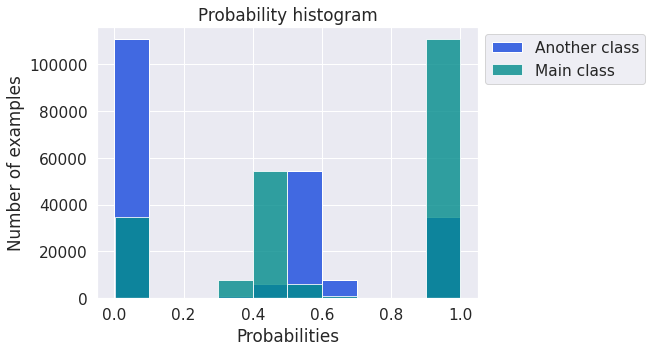

In [56]:
figure = plt.figure(figsize = (15, 5))

plt2 = figure.add_subplot(122)
plt2.hist(predictions_proba[:, 0], 
          label='Another class', color='royalblue', alpha=1)
plt2.hist(predictions_proba[:, 1], 
          label='Main class', color='darkcyan', alpha=0.8)
plt2.set_ylabel('Number of examples')
plt2.set_xlabel('Probabilities')
plt2.set_title('Probability histogram')
plt2.legend(bbox_to_anchor=(1, 1))

plt.show()

In [57]:
# change threshold
predictions = np.where(predictions_proba[:, 1] > 0.3, 1, 0)
predictions

array([1, 1, 1, ..., 1, 1, 0])

In [58]:
sample['Predicted'] = predictions
sample

,Id,Predicted
0,19843,1
1,471287,1
2,342522,1
3,457799,1
4,233778,1
...,...,...
214604,16841,1
214605,69348,1
214606,594974,1
214607,320024,1


In [59]:
sample.Predicted.value_counts()

1    179901
0     34708
Name: Predicted, dtype: int64

In [60]:
sample.to_csv('submit.csv', index=False)